In [1]:
import ROOT
import uproot
import numpy as np
import pandas as pd
import torch 
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.22/08


In [2]:
sig_df = pd.read_pickle('Pkl_ips/SC_SUSY_242_5_mchi_60_all.pkl')
tt_df  = pd.read_pickle('Pkl_ips/SC_ttbar_all.pkl')
vv_df  = pd.read_pickle('Pkl_ips/SC_VV_all.pkl')
st_df  = pd.read_pickle('Pkl_ips/SC_ST_all.pkl')
sat_df = pd.read_pickle('Pkl_ips/SC_SAT_all.pkl')

In [3]:
root_file = uproot.open('Root_files/SUSY_242_5_60.root')['Step8']
sc_weight = root_file['sc_weight'].array() 

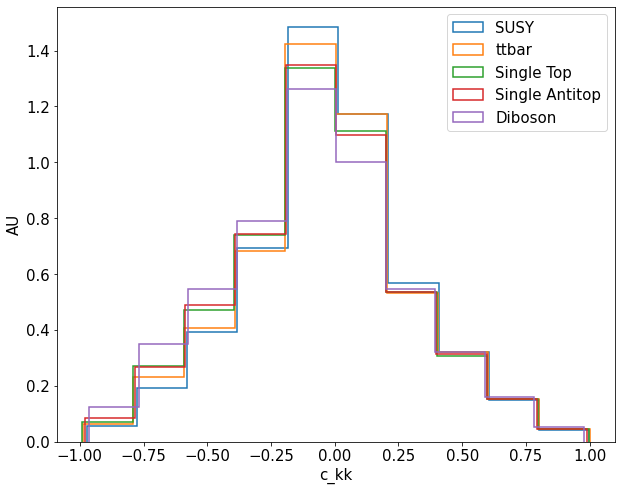

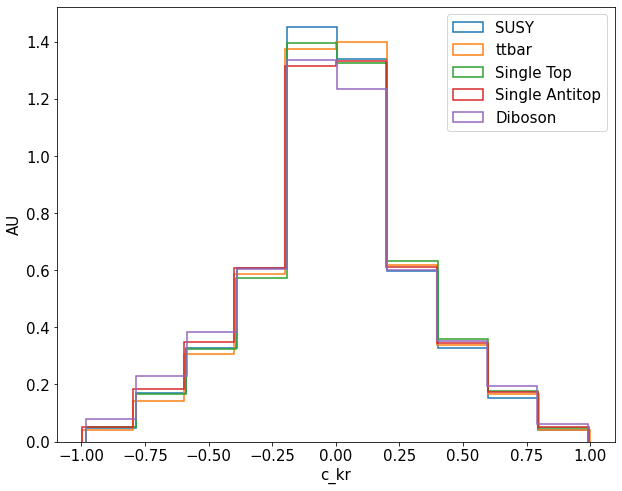

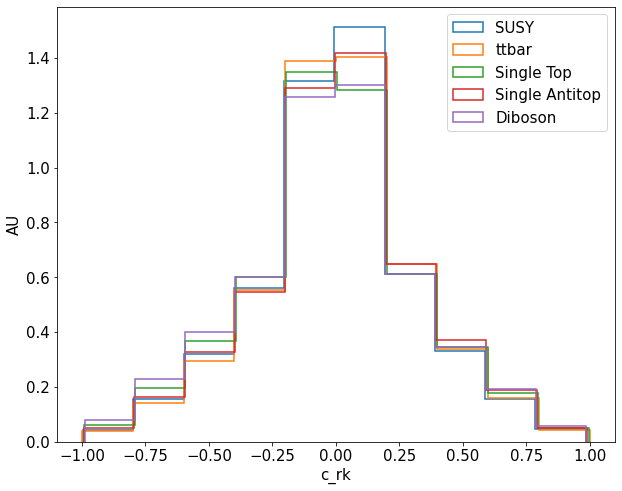

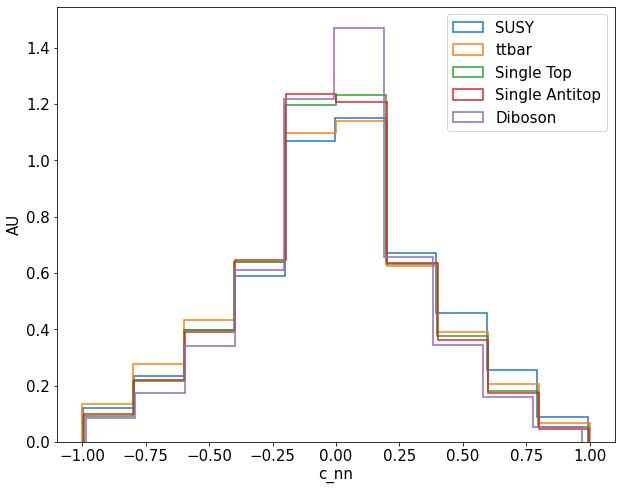

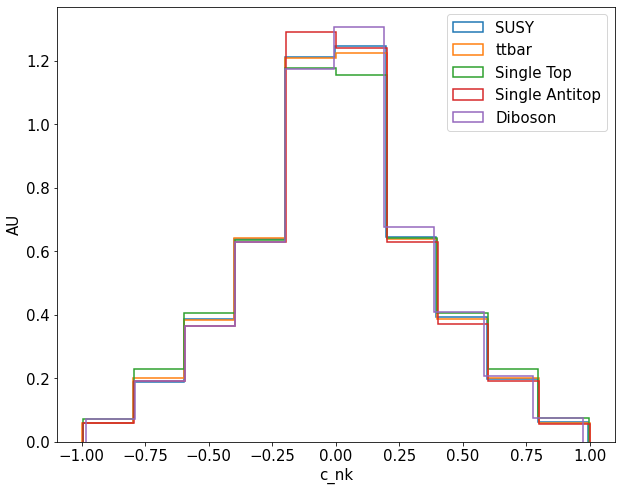

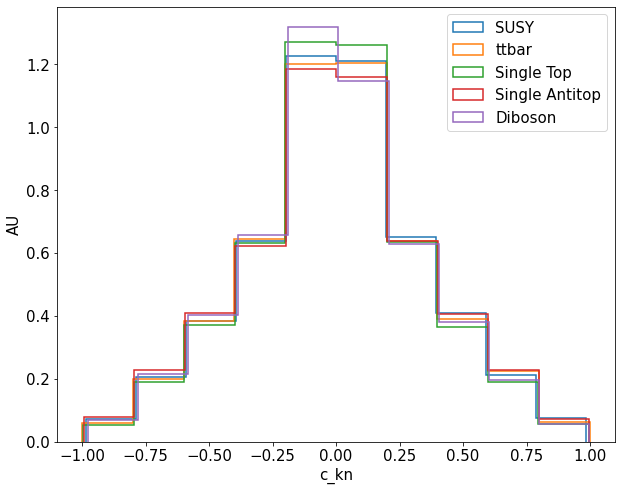

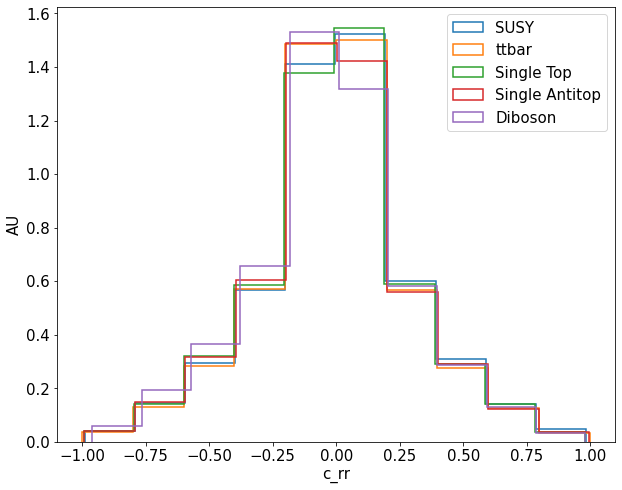

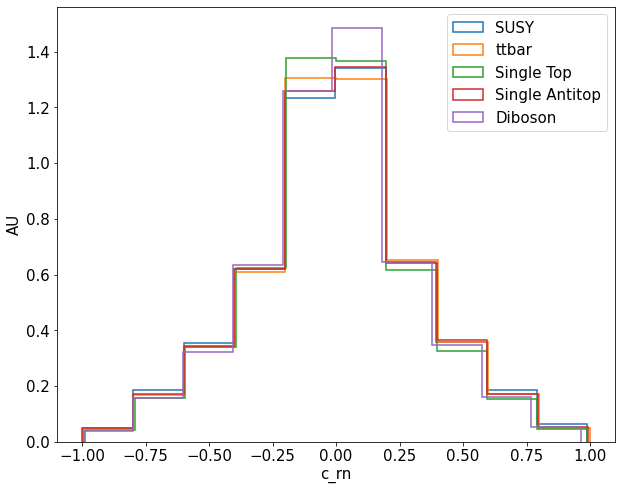

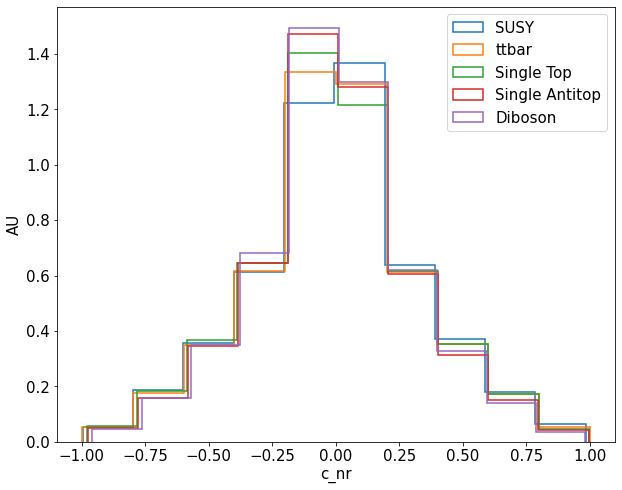

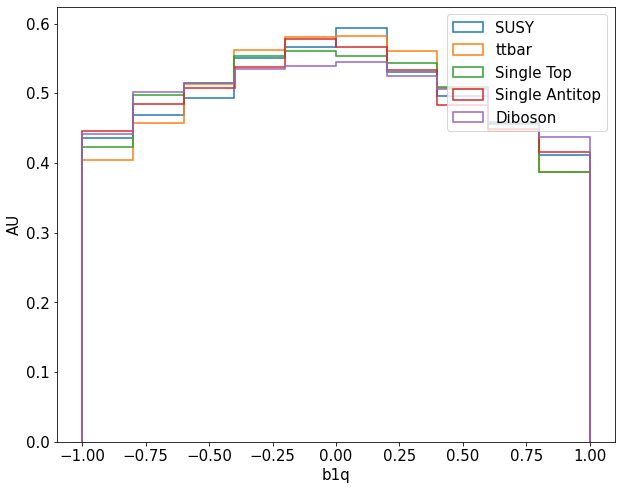

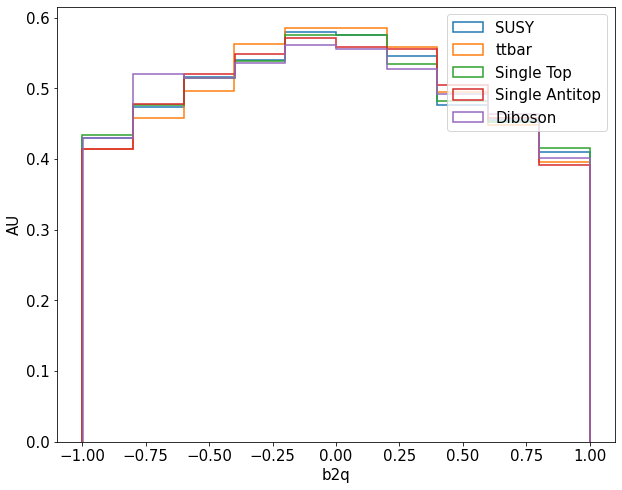

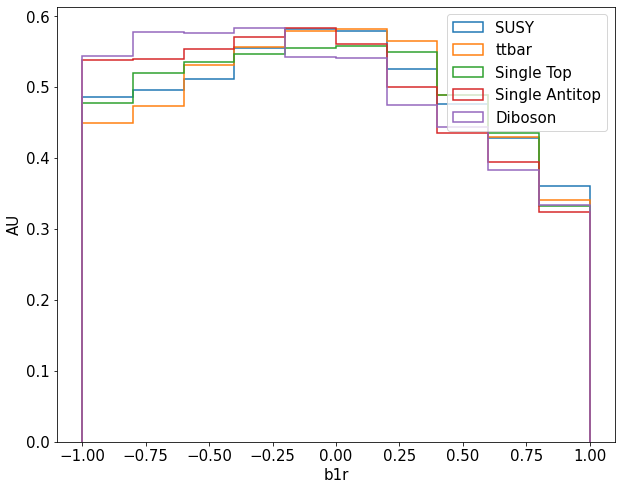

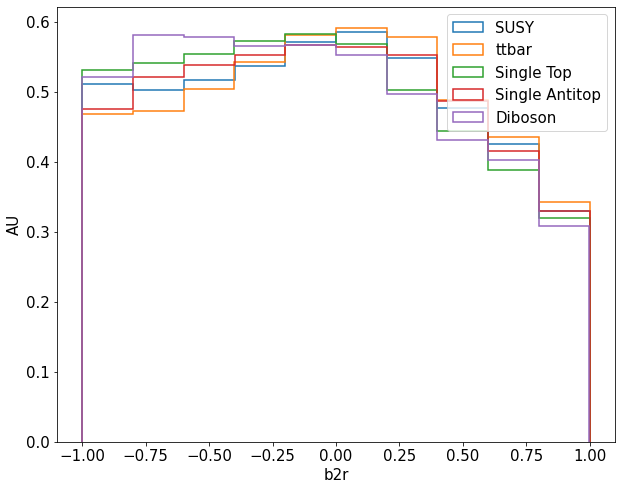

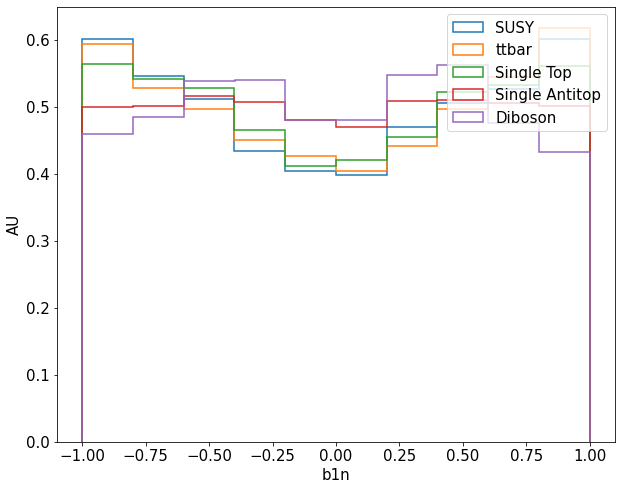

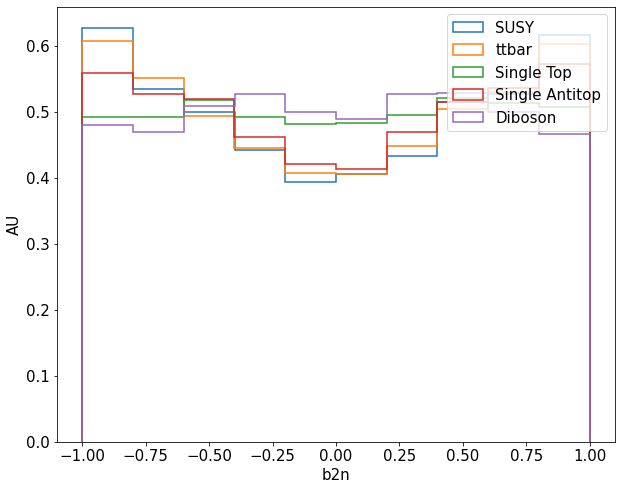

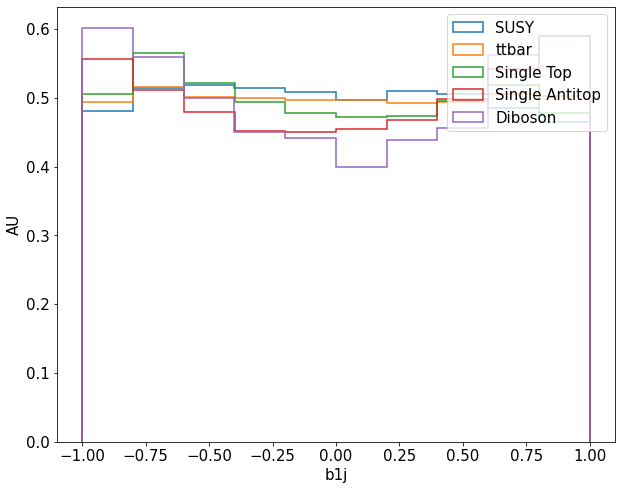

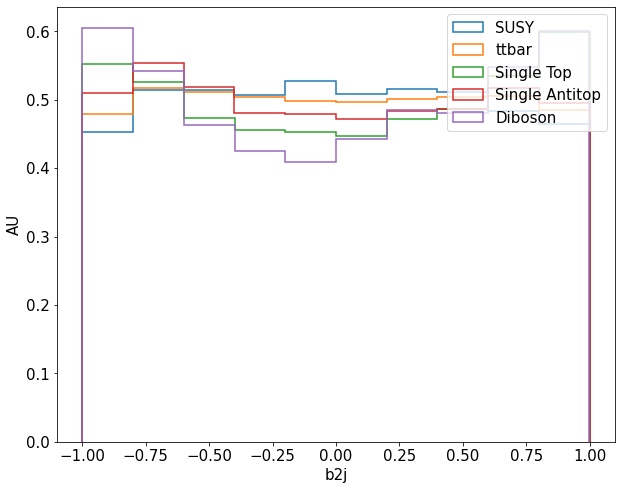

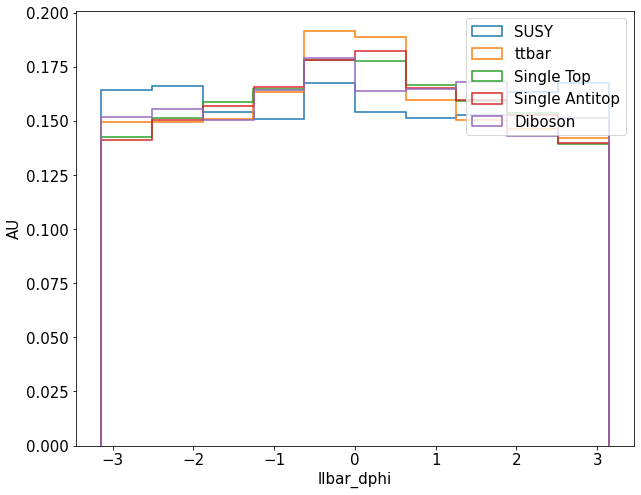

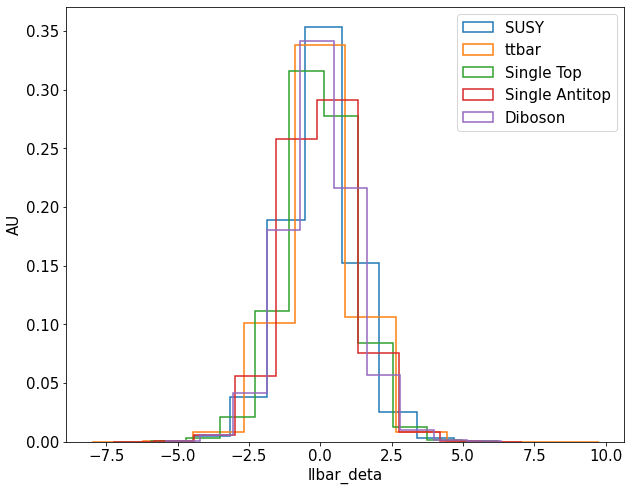

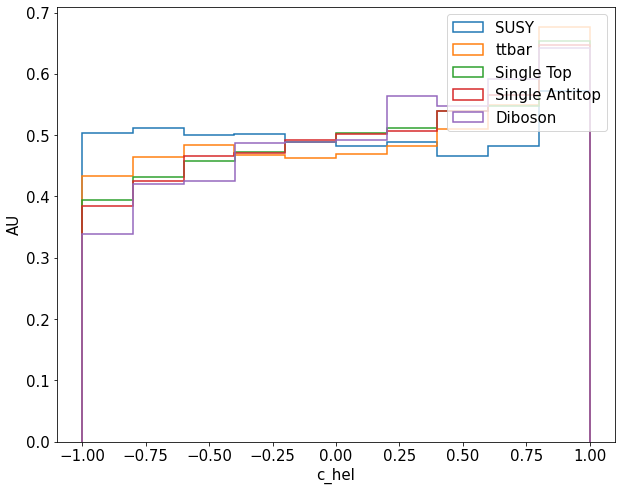

In [3]:
x_labels = sig_df.columns
count    = 0

for i in sig_df.columns :
    plt.figure(figsize=(10,8))
    # Plot the histograms
    plt.hist(sig_df[i], histtype='step', density=True, linewidth=1.5, label='SUSY')
    plt.hist(tt_df[i] , histtype='step', density=True, linewidth=1.5, label='ttbar')
    plt.hist(st_df[i] , histtype='step', density=True, linewidth=1.5, label='Single Top')
    plt.hist(sat_df[i], histtype='step', density=True, linewidth=1.5, label='Single Antitop')
    plt.hist(vv_df[i] , histtype='step', density=True, linewidth=1.5, label='Diboson')
    
    # Formatting
    plt.xlabel(x_labels[count], fontsize=15)
    plt.ylabel('AU', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15)

    img_name = 'Images/Mstop_242_5_' + str(x_labels[count]) + '.jpg' 
    count   += 1
    plt.savefig(img_name)

In [4]:
# Standardize
sig_mean = sig_df.mean()
sig_std  = sig_df.std()

tt_mean = tt_df.mean()
tt_std  = tt_df.std()

st_mean = st_df.mean()
st_std  = st_df.std()

vv_mean = vv_df.mean()
vv_std  = vv_df.std()

sat_mean = sat_df.mean()
sat_std  = sat_df.std()

sig_df = (sig_df - sig_mean)/ sig_std
tt_df  = (tt_df  - tt_mean)/ tt_std
st_df  = (st_df  - st_mean)/ st_std
vv_df  = (vv_df  - vv_mean)/ vv_std
sat_df = (sat_df  - sat_mean)/ sat_std

In [5]:
# Lumi weights
w_tt  = 17.994815 * np.ones(len(tt_df))
w_st  = 8.706901  * np.ones(len(st_df))
w_sat = 8.706901  * np.ones(len(sat_df))
w_vv  = 2.580743  * np.ones(len(vv_df))
w_SUSY= 14.38951  * np.ones(len(sig_df))

In [6]:
w_SUSY = np.multiply(np.array(sc_weight), w_SUSY)

In [7]:
# Set both to equal sizes 
# Reducing the bkg dataframe size

sig_df_train = sig_df[1:13000]
tt_df_train  = tt_df[1:20000]
st_df_train  = st_df[1:5000]
sat_df_train = sat_df[1:5000]
vv_df_train  = vv_df[1:2000]

In [8]:
sig_df_wt    = w_SUSY[1:13000]
tt_df_wt     = w_tt[1:20000]
st_df_wt     = w_st[1:5000]
vv_df_wt     = w_vv[1:2000]
sat_df_wt    = w_sat[1:5000]

In [9]:
bkgList = [tt_df_train, st_df_train, sat_df_train, vv_df_train]  # List of your dataframes
bkgWts  = [tt_df_wt   , st_df_wt   , sat_df_wt   , vv_df_wt]

bkg_df_train = pd.concat(bkgList)
bkg_df_wt    = np.concatenate(bkgWts)

signal = sig_df_train.values
bkg    = bkg_df_train.values

sig_label = np.ones(len(signal))
bkg_label = np.zeros(len(bkg))

data      = np.concatenate((signal,bkg))
label     = np.concatenate((sig_label,bkg_label))
sample_wts= np.concatenate((sig_df_wt, bkg_df_wt))

In [10]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2, shuffle=True)
skf.get_n_splits(data, label)
skf.split(data, label)

<generator object _BaseKFold.split at 0x7faa8c0ac820>

In [11]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]
    x_train_wt, x_test_wt = sample_wts[train_index], sample_wts[test_index]

TRAIN: [    2     3     8 ... 44990 44992 44993] TEST: [    0     1     4 ... 44989 44991 44994]
TRAIN: [    0     1     4 ... 44989 44991 44994] TEST: [    2     3     8 ... 44990 44992 44993]


In [12]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]
x_train_wt = x_train_wt[idx]

In [54]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout, BatchNormalization
from skopt import gp_minimize

model = Sequential()
model.add(Dense(150, input_dim = 39  ,activation='relu'))
model.add(Dropout(0.4))
#model.add(BatchNormalization())
#model.add(Dense(100, input_dim = 100 ,activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 150)               6000      
_________________________________________________________________
dropout_3 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 151       
Total params: 6,151
Trainable params: 6,151
Non-trainable params: 0
_________________________________________________________________


In [15]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [55]:
hist = model.fit(x_train, y_train, batch_size=30, epochs=500,verbose=1, shuffle=True, validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
                  ModelCheckpoint(filepath='model.h5', verbose=0)])

Epoch 1/500
600/600 [==============================] - 3s 4ms/step - loss: 0.6588 - accuracy: 0.6524 - val_loss: 0.5967 - val_accuracy: 0.7162
Epoch 2/500
600/600 [==============================] - 2s 3ms/step - loss: 0.6063 - accuracy: 0.7100 - val_loss: 0.5961 - val_accuracy: 0.7162
Epoch 3/500
600/600 [==============================] - 2s 3ms/step - loss: 0.6040 - accuracy: 0.7073 - val_loss: 0.5950 - val_accuracy: 0.7162
Epoch 4/500
600/600 [==============================] - 2s 3ms/step - loss: 0.5924 - accuracy: 0.7188 - val_loss: 0.5933 - val_accuracy: 0.7162
Epoch 5/500
600/600 [==============================] - 2s 3ms/step - loss: 0.6040 - accuracy: 0.7035 - val_loss: 0.5887 - val_accuracy: 0.7162
Epoch 6/500
600/600 [==============================] - 2s 3ms/step - loss: 0.5943 - accuracy: 0.7120 - val_loss: 0.5882 - val_accuracy: 0.7162
Epoch 7/500
600/600 [==============================] - 2s 3ms/step - loss: 0.5982 - accuracy: 0.7046 - val_loss: 0.5904 - val_accuracy: 0.7162

Epoch 58/500
600/600 [==============================] - 2s 3ms/step - loss: 0.4182 - accuracy: 0.8056 - val_loss: 0.3585 - val_accuracy: 0.8498
Epoch 59/500
600/600 [==============================] - 2s 3ms/step - loss: 0.4204 - accuracy: 0.8072 - val_loss: 0.3660 - val_accuracy: 0.8213
Epoch 60/500
600/600 [==============================] - 2s 3ms/step - loss: 0.4065 - accuracy: 0.8186 - val_loss: 0.3525 - val_accuracy: 0.8424
Epoch 61/500
600/600 [==============================] - 2s 3ms/step - loss: 0.4054 - accuracy: 0.8167 - val_loss: 0.3620 - val_accuracy: 0.8122
Epoch 62/500
600/600 [==============================] - 1s 2ms/step - loss: 0.4088 - accuracy: 0.8155 - val_loss: 0.3428 - val_accuracy: 0.8636
Epoch 63/500
600/600 [==============================] - 2s 3ms/step - loss: 0.4044 - accuracy: 0.8170 - val_loss: 0.3469 - val_accuracy: 0.8498
Epoch 64/500
600/600 [==============================] - 1s 2ms/step - loss: 0.4009 - accuracy: 0.8156 - val_loss: 0.3307 - val_accuracy:

Epoch 115/500
600/600 [==============================] - 1s 2ms/step - loss: 0.2677 - accuracy: 0.8892 - val_loss: 0.1822 - val_accuracy: 0.9438
Epoch 116/500
600/600 [==============================] - 2s 3ms/step - loss: 0.2613 - accuracy: 0.8917 - val_loss: 0.1689 - val_accuracy: 0.9629
Epoch 117/500
600/600 [==============================] - 2s 3ms/step - loss: 0.2595 - accuracy: 0.8925 - val_loss: 0.1701 - val_accuracy: 0.9551
Epoch 118/500
600/600 [==============================] - 1s 2ms/step - loss: 0.2604 - accuracy: 0.8935 - val_loss: 0.1847 - val_accuracy: 0.9378
Epoch 119/500
600/600 [==============================] - 2s 3ms/step - loss: 0.2601 - accuracy: 0.8936 - val_loss: 0.1844 - val_accuracy: 0.9347
Epoch 120/500
600/600 [==============================] - 1s 2ms/step - loss: 0.2662 - accuracy: 0.8888 - val_loss: 0.1656 - val_accuracy: 0.9567
Epoch 121/500
600/600 [==============================] - 1s 2ms/step - loss: 0.2550 - accuracy: 0.8931 - val_loss: 0.1675 - val_ac

600/600 [==============================] - 1s 2ms/step - loss: 0.1947 - accuracy: 0.9187 - val_loss: 0.1037 - val_accuracy: 0.9740
Epoch 172/500
600/600 [==============================] - 2s 3ms/step - loss: 0.1818 - accuracy: 0.9286 - val_loss: 0.1000 - val_accuracy: 0.9740
Epoch 173/500
600/600 [==============================] - 1s 2ms/step - loss: 0.1967 - accuracy: 0.9185 - val_loss: 0.1023 - val_accuracy: 0.9747
Epoch 174/500
600/600 [==============================] - 1s 2ms/step - loss: 0.1834 - accuracy: 0.9261 - val_loss: 0.0995 - val_accuracy: 0.9764
Epoch 175/500
600/600 [==============================] - 1s 2ms/step - loss: 0.1809 - accuracy: 0.9285 - val_loss: 0.1049 - val_accuracy: 0.9676
Epoch 176/500
600/600 [==============================] - 1s 2ms/step - loss: 0.1845 - accuracy: 0.9258 - val_loss: 0.0976 - val_accuracy: 0.9758
Epoch 177/500
600/600 [==============================] - 2s 3ms/step - loss: 0.1870 - accuracy: 0.9224 - val_loss: 0.0991 - val_accuracy: 0.9724

600/600 [==============================] - 1s 1ms/step - loss: 0.1489 - accuracy: 0.9411 - val_loss: 0.0729 - val_accuracy: 0.9816
Epoch 228/500
600/600 [==============================] - 1s 1ms/step - loss: 0.1375 - accuracy: 0.9478 - val_loss: 0.0774 - val_accuracy: 0.9798
Epoch 229/500
600/600 [==============================] - 1s 2ms/step - loss: 0.1540 - accuracy: 0.9394 - val_loss: 0.0702 - val_accuracy: 0.9816
Epoch 230/500
600/600 [==============================] - 1s 2ms/step - loss: 0.1474 - accuracy: 0.9414 - val_loss: 0.0724 - val_accuracy: 0.9816
Epoch 231/500
600/600 [==============================] - 1s 2ms/step - loss: 0.1599 - accuracy: 0.9364 - val_loss: 0.0732 - val_accuracy: 0.9787
Epoch 232/500
600/600 [==============================] - 1s 2ms/step - loss: 0.1460 - accuracy: 0.9416 - val_loss: 0.0619 - val_accuracy: 0.9876
Epoch 233/500
600/600 [==============================] - 1s 2ms/step - loss: 0.1477 - accuracy: 0.9418 - val_loss: 0.0675 - val_accuracy: 0.9816

In [35]:
# serialize model to JSON
model_json = model.to_json()
with open("Models/Mstop_242_5_mchi_60.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Models/Mstop_242_5_mchi_60.h5")
print("Saved model to disk")

Saved model to disk


In [17]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch', fontsize=17)
    plt.ylabel('Loss' , fontsize=17)
    plt.tick_params(axis="y", labelsize=15)
    plt.tick_params(axis="x", labelsize=15)
    plt.title('Cross Entropy Loss by Epoch', fontsize=17)
    color='C0'
    do_acc=False
    for label,loss in histories:
        #color = tuple(np.random.random(3))
        #colors.append(color)
        l = 'Training set loss'
        vl= 'Validation set loss'
        if 'accuracy' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['accuracy'][-1])
            do_acc = True
        if 'val_accuracy' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_accuracy'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)

    plt.legend(fontsize=17)
    #plt.yscale('log')
    plt.show()
    
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch', fontsize=17)
    plt.ylabel('Accuracy' , fontsize=17)
    plt.tick_params(axis="y", labelsize=15)
    plt.tick_params(axis="x", labelsize=15)
    for i,(label,loss) in enumerate(histories):
        #color = colors[i]
        if 'accuracy' in loss.history:
            plt.plot(loss.history['accuracy'], lw=2, label=label+" accuracy", color=color)
        if 'val_accuracy' in loss.history:
            plt.plot(loss.history['val_accuracy'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(fontsize=17)
    plt.show()

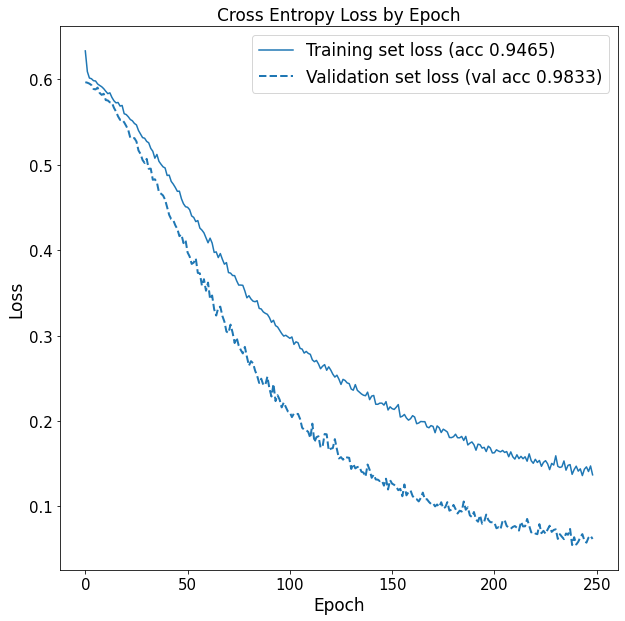

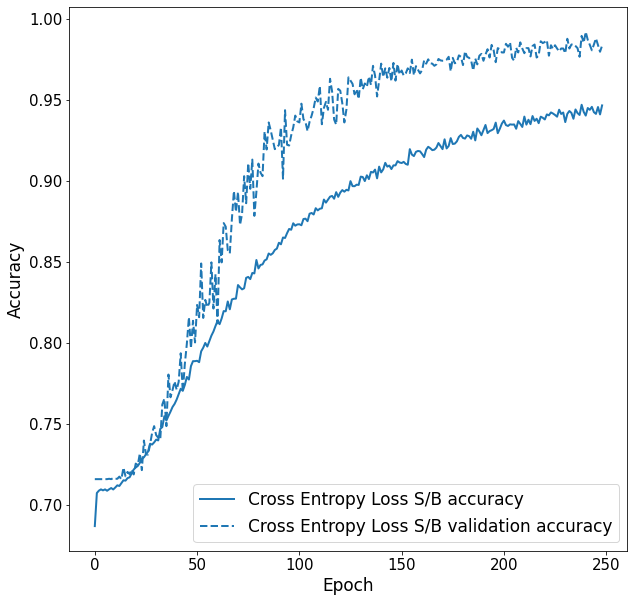

In [56]:
show_losses( [("Cross Entropy Loss S/B", hist)])

In [57]:
from sklearn.metrics import roc_curve
y_pred_train = model.predict(x_train).ravel()
y_pred_test  = model.predict(x_test).ravel()

fpr_keras_train, tpr_keras_train, thresholds_keras = roc_curve(y_train, y_pred_train)
fpr_keras_test , tpr_keras_test , thresholds_keras = roc_curve(y_test , y_pred_test)

In [58]:
from sklearn.metrics import auc
auc_keras_test  = auc(fpr_keras_test, tpr_keras_test)
auc_keras_train = auc(fpr_keras_train, tpr_keras_train)

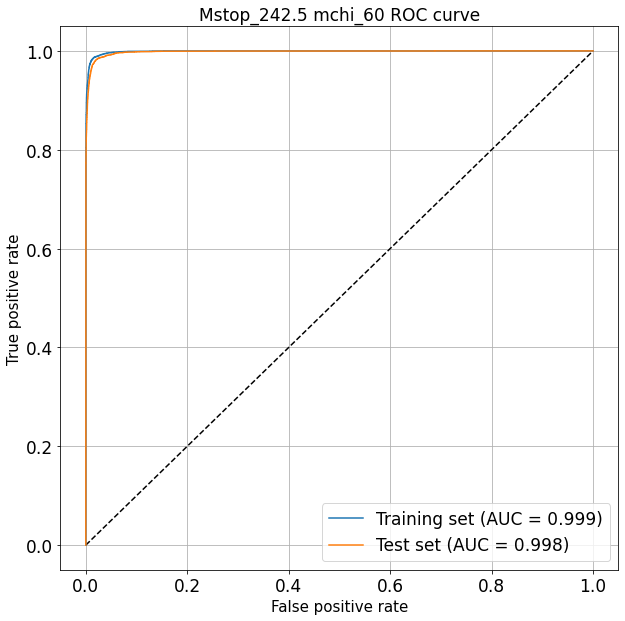

In [38]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_train, tpr_keras_train, label='Training set (AUC = {:.3f})'.format(auc_keras_train))
plt.plot(fpr_keras_test , tpr_keras_test , label='Test set (AUC = {:.3f})'.format(auc_keras_test))
plt.tick_params(axis="y", labelsize=17)
plt.tick_params(axis="x", labelsize=17)
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate' , fontsize=15)
plt.title('Mstop_242.5 mchi_60 ROC curve', fontsize=17)
plt.legend(loc='lower right', fontsize=17)
plt.grid()
#plt.savefig('ROC Mstop 242.5 Mchi 60.jpg')
plt.show()

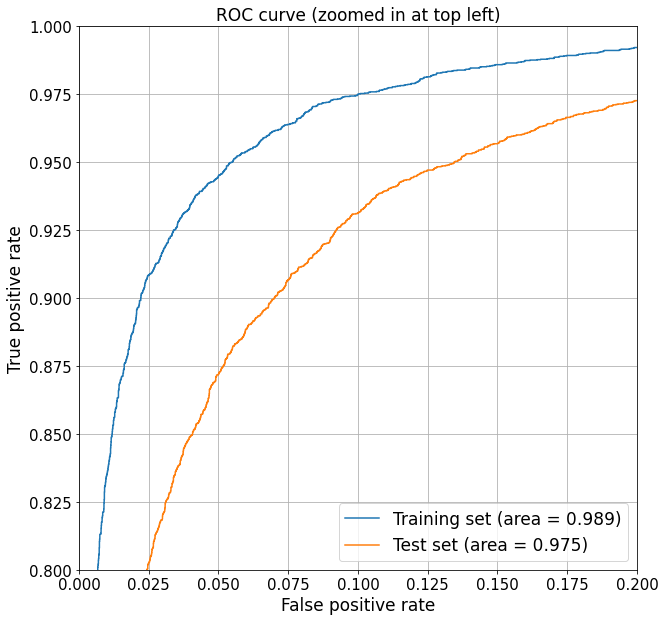

In [42]:
# Zoom in view of the upper left corner.
plt.figure(figsize=(10,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_train, tpr_keras_train, label='Training set (area = {:.3f})'.format(auc_keras_train))
plt.plot(fpr_keras_test , tpr_keras_test , label='Test set (area = {:.3f})'.format(auc_keras_test))
plt.ylabel('True positive rate' , fontsize=17)
plt.xlabel('False positive rate', fontsize=17)
plt.tick_params(axis="y", labelsize=15)
plt.tick_params(axis="x", labelsize=15)
plt.title('ROC curve (zoomed in at top left)', fontsize=17)
plt.legend(loc='best', fontsize=17)
plt.grid()
plt.show()

In [62]:
tt_pred  = model.predict(tt_df[20000:]) 
st_pred  = model.predict(st_df[5000:])
sat_pred = model.predict(sat_df[5000:])
vv_pred  = model.predict(vv_df[2000:]) 
si_pred  = model.predict(sig_df[13000:])

2021-05-07 04:10:44.579845: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 366416544 exceeds 10% of free system memory.


In [63]:
tt_pred_wt  = w_tt[20000:]
st_pred_wt  = w_st[5000:]
sat_pred_wt = w_sat[5000:]
vv_pred_wt  = w_vv[2000:]
si_pred_wt  = w_SUSY[13000:]

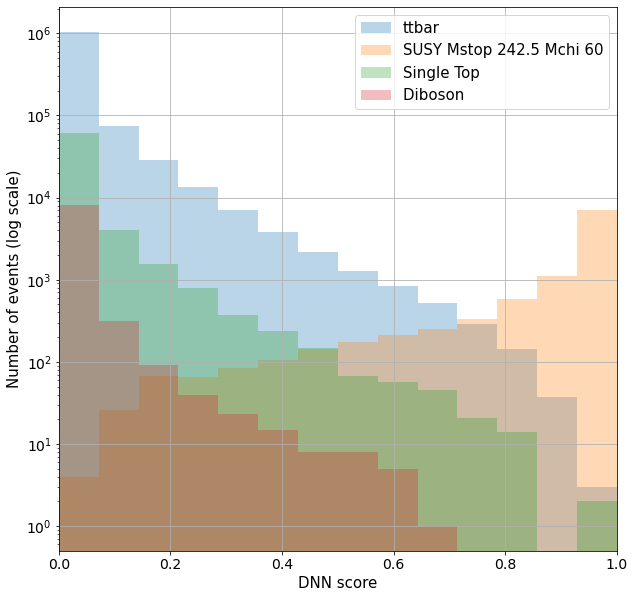

In [64]:
binning = np.linspace(0,1,15)
plt.figure(figsize=(10,10))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)

plt.hist(tt_pred, bins=binning, alpha=0.3, label='ttbar')
plt.hist(si_pred, bins=binning, alpha=0.3, label='SUSY Mstop 242.5 Mchi 60')
plt.hist(st_pred, bins=binning, alpha=0.3, label='Single Top')
plt.hist(vv_pred, bins=binning, alpha=0.3, label='Diboson ')

#plt.hist(tt_pred, bins=binning, alpha=0.3, weights= tt_pred_wt, label='ttbar')
#plt.hist(si_pred, bins=binning, alpha=0.3, weights= si_pred_wt, label='SUSY Mstop 242.5 Mchi 60')
#plt.hist(st_pred, bins=binning, alpha=0.3, weights= st_pred_wt, label='Single Top')
#plt.hist(vv_pred, bins=binning, alpha=0.3, weights= vv_pred_wt, label='Diboson ')
#plt.hist(sat_pred, bins=15, alpha=0.3, label='Single Antitop')

plt.yscale('log')
plt.xlim(0,1)
#plt.ylim(0,3e7)
plt.xlabel('DNN score', fontsize=15)
plt.ylabel('Number of events (log scale)', fontsize=15)
plt.grid()
plt.legend(loc='best', fontsize=15)
#plt.savefig('Images/DNN score Mstop_242.5 Mchi_60.jpg')

In [28]:
np.savetxt('DNN_pred/Mstop_242_5_mchi_60_SUSY_pred_simpler.txt', si_pred)
np.savetxt('DNN_pred/Mstop_242_5_mchi_60_tt_pred_simpler.txt'  , tt_pred)
np.savetxt('DNN_pred/Mstop_242_5_mchi_60_st_pred_simpler.txt'  , st_pred)
np.savetxt('DNN_pred/Mstop_242_5_mchi_60_sat_pred_simpler.txt' , sat_pred)
np.savetxt('DNN_pred/Mstop_242_5_mchi_60_vv_pred_simpler.txt'  , vv_pred)

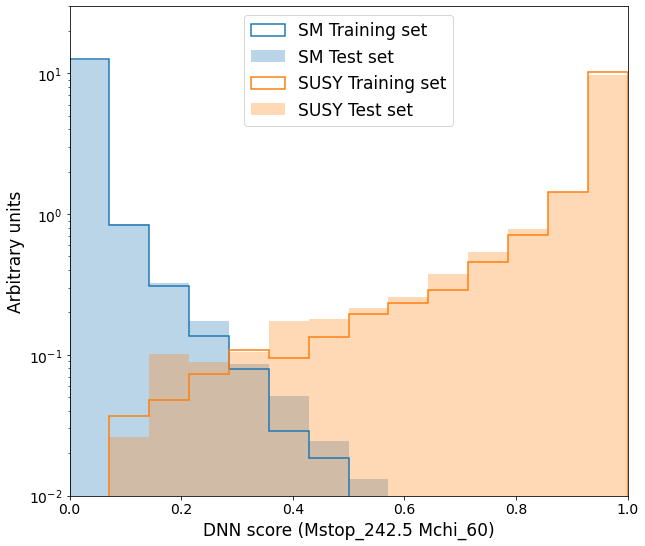

In [59]:
c0 = 'C0'
c1 = 'C1'

binning = np.linspace(0,1, 15)

plt.figure(figsize=(10,9))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(y_pred_train[y_train == 0], bins=binning, label='SM Training set', histtype='step', linestyle='solid', linewidth=1.5, density=True, color=c0)
plt.hist(y_pred_test[y_test == 0]  , bins=binning, label='SM Test set'    , alpha=0.3, linewidth=1.5, density=True , color=c0)
plt.hist(y_pred_train[y_train == 1], bins=binning, label='SUSY Training set', histtype='step' , linestyle='solid', linewidth=1.5, density=True, color=c1)
plt.hist(y_pred_test[y_test == 1]  , bins=binning, label='SUSY Test set ', alpha=0.3, linewidth=1.5, density=True, color=c1)

plt.yscale('log')
plt.ylim(0.01, 30)
plt.xlim(0,1)
plt.xlabel('DNN score (Mstop_242.5 Mchi_60)', fontsize=17)
plt.ylabel('Arbitrary units', fontsize=17)
plt.legend(loc='upper center', fontsize=17)
#plt.savefig('Train vs test Mstop_242.5 Mchi_60.jpg')

In [72]:
def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()
    sns.set(font_scale=1.4)
    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(15, 12))

    # Add diverging colormap from red to blue
    #cmap = sns.diverging_palette(250, 10, as_cmap=True)
    #cmap  = sns.color_palette("coolwarm")
    cmap = sns.diverging_palette(0,255,sep=1, as_cmap=True)
                                 
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        hm = sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax, vmin=-1, vmax=1)
        plt.title('Correlation matrix for input features', fontsize=30)
        plt.savefig('ip_features_corr.png')
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax, vmin=-1, vmax=1)

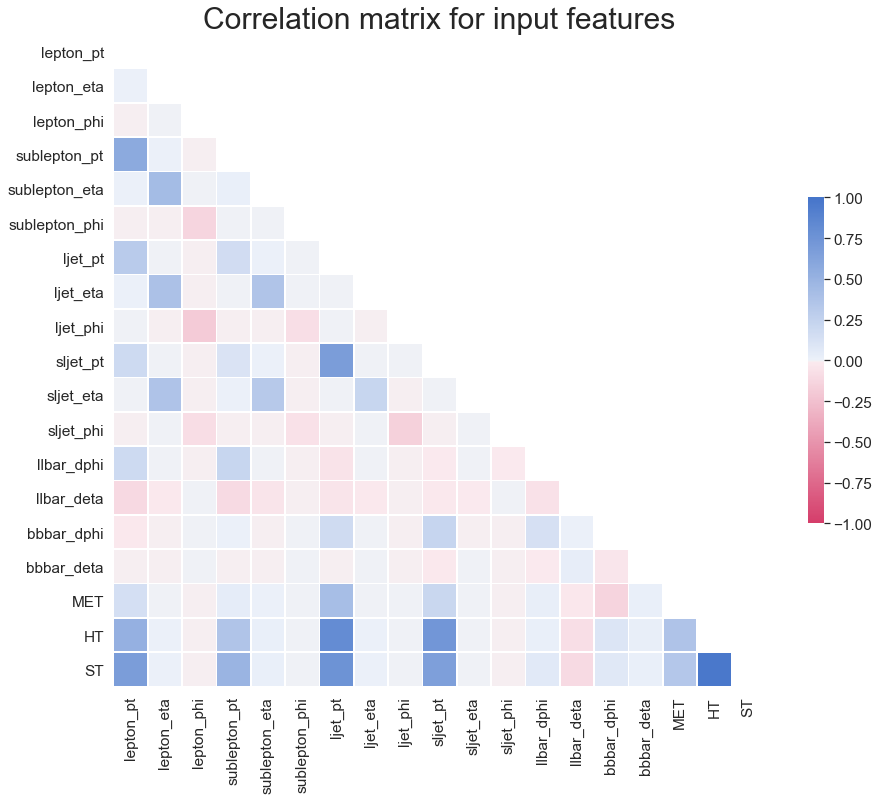

In [73]:
CorrMtx(corr, dropDuplicates = True)

In [44]:
# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

In [45]:
import shap

In [46]:
# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [53]:
e.shap_values(x_test[1:3])

[array([[-1.37136276e-03,  1.95421929e-01,  2.94544261e-03,
          2.35565552e-01, -3.17621256e-02, -2.44010452e-01,
         -2.37234645e-02, -3.17079084e-03, -2.55050165e-02,
          1.93937034e-01,  2.60713533e-02, -4.62115004e-03,
          3.96051060e-03,  3.48572073e-02,  2.82899322e-01,
          1.18178008e+00,  1.05318110e+00,  2.86249731e-02,
         -2.31568756e-02,  2.00573420e-01, -2.52693423e-02,
          1.52199845e-01,  7.77932437e-01, -2.51948639e-01,
          2.58644801e-01, -3.38318788e+00, -8.26761909e-02,
          4.43801146e-01, -2.08906943e-01,  1.47372857e-01,
          1.34531331e-02,  1.21431988e-03, -4.61306871e-04,
          3.62795176e-01, -6.41550397e-01,  9.93037845e-04,
         -2.03772526e-02, -2.49602872e-02,  1.59735010e-01],
        [-4.53308760e-01, -3.01118210e-02, -1.70571146e-01,
          6.23943625e-01,  4.74727753e-03,  1.11519262e-01,
          2.49236153e-01,  2.01061302e-01, -1.43037660e-02,
         -3.40577642e-01, -5.73726989e-